## Arch_NN. Autumn 2022.
### TASK 6. Sorokin Mikhail group J42322c.

# Automatic Music Generation

* In this assignment you will create several two network architectures: LSTM and WaveNet for generating music. 
* You will train a model using a collection of piano MIDI files from the MAESTRO dataset.
* After completing the task you will be able to generate a new music track.

This notebook uses the `pretty_midi` library to create and parse MIDI files, and `pyfluidsynth` for generating audio playback in Colab.

**Tasks description:**

* Design the architecture of two models for generating piano melodies with the specified parameters: LSTM and WaveNet.
* Perform experiments with different input note sequence lengths and draw conclusions about which value of this hyperparameter gives the best result for each of the models.

## Import libraries

In [1]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (1.1.9-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

## Downloading and exploring data

In [3]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

### **Download MAESTRO dataset**

In [4]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

In [5]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


### **Explore the MIDI file**

First, we will use `pretty_midi` to parse a single MIDI file and inspect the format of the notes. If you would like to download the MIDI file below to play on your computer, you can do so in colab by writing `files.download(sample_file)`.

In [6]:
sample_file = filenames[1]
print(sample_file)

data/maestro-v2.0.0/2008/MIDI-Unprocessed_08_R3_2008_01-05_ORIG_MID--AUDIO_08_R3_2008_wav--3.midi


In [7]:
# Generate a PrettyMIDI object for the sample MIDI file
pm = pretty_midi.PrettyMIDI(sample_file)

In [8]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [9]:
# Play the sample file. The playback widget may take several seconds to load.
display_audio(pm)

In [10]:
# Do some inspection on the MIDI file. What kinds of instruments are used?
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


### **Extract notes from MIDI file**

You will use three variables to represent a note when training the model: 
* pitch (erceptual quality of the sound as a MIDI note number);
* step (time elapsed from the previous note or start of the track);
* duration (how long the note will be playing in seconds - the difference between the note end and note start times).

Extract the notes from the sample MIDI file.

In [11]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [12]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

pitch     start       end      step  duration
0     69  0.954427  3.233073  0.000000  2.278646
1     65  0.980469  1.734375  0.026042  0.753906
2     50  0.989583  2.023438  0.009115  1.033854
3     62  0.993490  1.763021  0.003906  0.769531
4     60  1.707031  2.483073  0.713542  0.776042

It may be easier to interpret the note names rather than the pitches, so you can use the function below to convert from the numeric pitch values to note names. The note name shows the type of note, accidental and octave number (e.g. C#4).

In [13]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['A4', 'F4', 'D3', 'D4', 'C4', 'E4', 'D4', 'B3', 'E3', 'G#4'],
      dtype='<U3')

To visualize the musical piece, plot the note pitch, start and end across the length of the track (i.e. piano roll). Visualise the first 1000 notes using the function below.

In [14]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

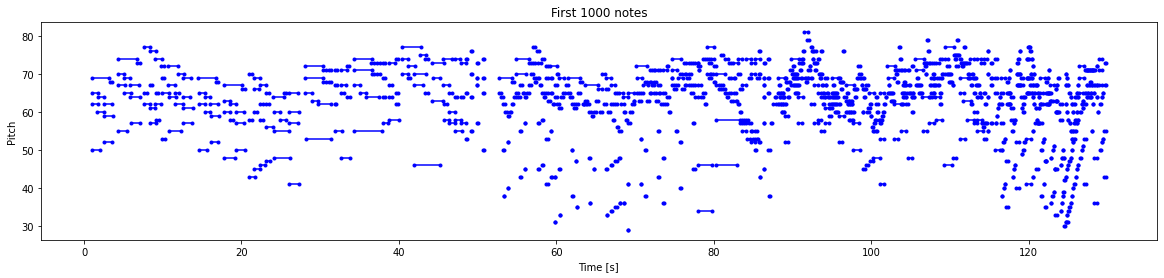

In [15]:
plot_piano_roll(raw_notes, count=1000)

Check the distribution of each note variable.

In [16]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

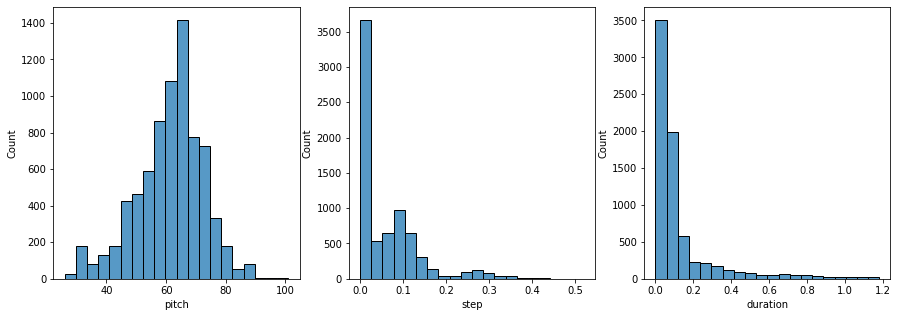

In [17]:
plot_distributions(raw_notes)

### **Create MIDI file from list of nodes**

You can generate your own MIDI file from a list of notes using the function below. You will use this function after models' training to voice the result of the prediction.

In [18]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [19]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

Play the generated MIDI file and see if there is any difference.

In [20]:
display_audio(example_pm)

## Create training Dataset

Create the training dataset by extracting notes from the MIDI files. You can start by using a small number of files, and experiment later with more. This may take a couple minutes.

In [21]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [22]:
all_notes[:10]

pitch     start       end      step  duration
0     44  0.942708  1.207031  0.000000  0.264323
1     83  1.015625  1.253906  0.072917  0.238281
2     87  1.260417  1.391927  0.244792  0.131510
3     83  1.398438  1.473958  0.138021  0.075521
4     80  1.507812  1.555990  0.109375  0.048177
5     56  1.604167  2.809896  0.096354  1.205729
6     63  1.634115  2.752604  0.029948  1.118490
7     59  1.641927  2.804688  0.007812  1.162760
8     80  1.648438  1.687500  0.006510  0.039062
9     83  1.735677  1.820312  0.087240  0.084635

In [23]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 17647


In [24]:
# Create a tf.data.Dataset from the parsed notes.
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [25]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

You will train the model on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and next note as the label. In this way, the model will be trained to predict the next note in a sequence.

In [26]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

The size of the vocabulary (vocab_size) is set to 128 representing all the pitches supported by `pretty_midi`.

Set the sequence length for each example. 

In [27]:
seq_length = 100
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(100, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

#### **TASK** 
Experiment with different lengths: 25, 50, 100 and 150 to see which one works best for the data. Draw brief conclusions from the results of the experiments. 

In [28]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (100, 3)
sequence elements (first 10): tf.Tensor(
[[0.34375    0.         0.26432292]
 [0.6484375  0.07291667 0.23828125]
 [0.6796875  0.24479167 0.13151042]
 [0.6484375  0.13802083 0.07552083]
 [0.625      0.109375   0.04817708]
 [0.4375     0.09635417 1.20572917]
 [0.4921875  0.02994792 1.11848958]
 [0.4609375  0.0078125  1.16276042]
 [0.625      0.00651042 0.0390625 ]
 [0.6484375  0.08723958 0.08463542]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=83.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.08854166666666607>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.09244791666666785>}


In [29]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [30]:
train_ds.element_spec

(TensorSpec(shape=(64, 100, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Create and train the models
Both models will have three outputs, one for each note variable. For pitch and duration, you will use a custom loss function based on mean squared error that encourages the model to output non-negative values.

In [31]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

### **LSTM model**

In [32]:
lstm_input_shape = (seq_length, 3)
lstm_learning_rate = 0.005

lstm_inputs = tf.keras.Input(lstm_input_shape)

# WRITE YOUR CODE HERE #

# + LSTM (128) with return sequences 
x1 = tf.keras.layers.LSTM(128, return_sequences=True)(lstm_inputs)

# + LSTM (128)
x2 = tf.keras.layers.LSTM(128)(x1)

# + Dense (256) 
x3 = tf.keras.layers.Dense(256)(x2)

# + ReLU activation
x4 = tf.keras.layers.ReLU()(x3)

# Replace None with the appropriate output values (depending on vocabulary size)
lstm_outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x4),
  'step': tf.keras.layers.Dense(1, name='step')(x4),
  'duration': tf.keras.layers.Dense(1, name='duration')(x4),
}

lstm_model = tf.keras.Model(lstm_inputs, lstm_outputs)

lstm_loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

lstm_optimizer = tf.keras.optimizers.Adam(learning_rate=lstm_learning_rate)

lstm_model.compile(loss=lstm_loss, optimizer=lstm_optimizer)

lstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 3)]     0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 100, 128)     67584       ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 128)          131584      ['lstm[0][0]']                   
                                                                                                  
 dense (Dense)                  (None, 256)          33024       ['lstm_1[0][0]']                 
                                                                                              

**Expected output shape and number of parameters (for vocabulary size 128)**

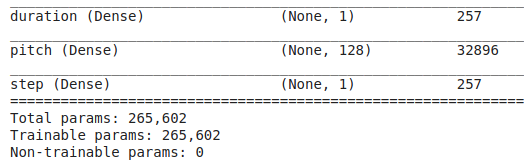

Testing the model.evaluate function, you can see that the pitch loss is significantly greater than the step and duration losses. Note that loss is the total loss computed by summing all the other losses and is currently dominated by the pitch loss.

In [33]:
lstm_losses = lstm_model.evaluate(train_ds, return_dict=True)
lstm_losses

274/274 [==============================] - 8s 9ms/step - loss: 5.0259 - duration_loss: 0.1320 - pitch_loss: 4.8557 - step_loss: 0.0382


{'loss': 5.02590274810791,
 'duration_loss': 0.13203813135623932,
 'pitch_loss': 4.855691432952881,
 'step_loss': 0.03817093372344971}

One way balance this is to use the loss_weights argument to compile:

In [34]:
lstm_model.compile(
    loss=lstm_loss,
    loss_weights={
        'pitch': 0.02,
        'step': 1.0,
        'duration':0.2,
    },
    optimizer=lstm_optimizer,
)

The loss then becomes the weighted sum of the individual losses.

In [35]:
lstm_model.evaluate(train_ds, return_dict=True)

274/274 [==============================] - 3s 7ms/step - loss: 0.1617 - duration_loss: 0.1320 - pitch_loss: 4.8557 - step_loss: 0.0382


{'loss': 0.16169242560863495,
 'duration_loss': 0.13203813135623932,
 'pitch_loss': 4.855691432952881,
 'step_loss': 0.03817093372344971}

In [36]:
lstm_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/lstm_ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [37]:
%%time
epochs = 30

history_lstm = lstm_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=lstm_callbacks,
)

Epoch 1/30
274/274 [==============================] - 7s 14ms/step - loss: 0.1230 - duration_loss: 0.0827 - pitch_loss: 4.0740 - step_loss: 0.0250
Epoch 2/30
274/274 [==============================] - 4s 13ms/step - loss: 0.1144 - duration_loss: 0.0732 - pitch_loss: 3.9432 - step_loss: 0.0209
Epoch 3/30
274/274 [==============================] - 4s 13ms/step - loss: 0.1134 - duration_loss: 0.0728 - pitch_loss: 3.9286 - step_loss: 0.0203
Epoch 4/30
274/274 [==============================] - 4s 13ms/step - loss: 0.1121 - duration_loss: 0.0724 - pitch_loss: 3.8792 - step_loss: 0.0200
Epoch 5/30
274/274 [==============================] - 4s 14ms/step - loss: 0.1099 - duration_loss: 0.0730 - pitch_loss: 3.7835 - step_loss: 0.0196
Epoch 6/30
274/274 [==============================] - 4s 13ms/step - loss: 0.1097 - duration_loss: 0.0724 - pitch_loss: 3.7674 - step_loss: 0.0198
Epoch 7/30
274/274 [==============================] - 4s 14ms/step - loss: 0.1084 - duration_loss: 0.0714 - pitch_loss

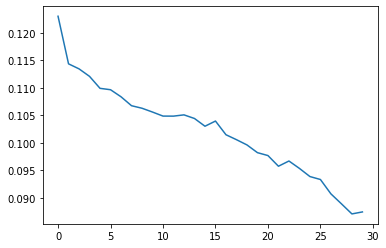

In [38]:
# Plot loss function
plt.plot(history_lstm.epoch, history_lstm.history['loss'], label='total loss')
plt.show()

### **WaveNet model**

You will implement a simplified WaveNet structure without adding residual and skip connections since the role of these layers is to improve the faster convergence.

In [39]:
wavenet_input_shape = (seq_length, 3)
wavenet_learning_rate = 0.005

wavenet_inputs = tf.keras.Input(wavenet_input_shape)

# WRITE YOUR CODE HERE #

# + 1D Causal Convolution (64 kernels with size 3, ReLU activation)
x1 = tf.keras.layers.Conv1D(64, 3, padding="same", activation='relu')(wavenet_inputs) 
# + Dropout 0.2
x2 =  tf.keras.layers.Dropout(0.2)(x1) 
# + MaxPool 2 
x3 = tf.keras.layers.MaxPool1D(2, padding="same")(x2)

# + Dilated 1D Causal Convolution (128 kernels with size 3, dilation = 2, ReLU activation) 
x4 = tf.keras.layers.Conv1D(128, 3, padding="same", dilation_rate=2, activation='relu')(x3)
# + Dropout 0.2 
x5 =  tf.keras.layers.Dropout(0.2)(x4)
# + MaxPool 2 
x6 = tf.keras.layers.MaxPool1D(2, padding="same")(x5)

# + Dilated 1D Causal Convolution (128 kernels with size 3, dilation = 2, ReLU activation)
x7 = tf.keras.layers.Conv1D(128, 3,padding="same",  dilation_rate=2, activation='relu')(x6) 
# + Dropout 0.2 
x8 =  tf.keras.layers.Dropout(0.2)(x7)
# + MaxPool 2 
x9 = tf.keras.layers.MaxPool1D(2, padding="same")(x8)

# + Dilated 1D Causal Convolution (256 kernels with size 3, dilation = 4, ReLU activation) 
x10 = tf.keras.layers.Conv1D(256, 3, padding="same", dilation_rate=4, activation='relu')(x9)
# + Dropout 0.2 
x11 =  tf.keras.layers.Dropout(0.2)(x10)
# + MaxPool 2 
x12 = tf.keras.layers.MaxPool1D(2, padding="same")(x11)

# + Global MaxPool
x13 = tf.keras.layers.GlobalMaxPool1D()(x12)

# Replace None with the appropriate output values (depending on vocabulary size)
wavenet_outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x13),
  'step': tf.keras.layers.Dense(1, name='step')(x13),
  'duration': tf.keras.layers.Dense(1, name='duration')(x13),
}

wavenet_model = tf.keras.Model(wavenet_inputs, wavenet_outputs)

wavenet_loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

wavenet_optimizer = tf.keras.optimizers.Adam(learning_rate=wavenet_learning_rate)

wavenet_model.compile(loss=wavenet_loss, optimizer=wavenet_optimizer)

wavenet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 3)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 100, 64)      640         ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 100, 64)      0           ['conv1d[0][0]']                 
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 50, 64)       0           ['dropout[0][0]']                
                                                                                            

**Expected output shape and number of parameters (for vocabulary size 128)**

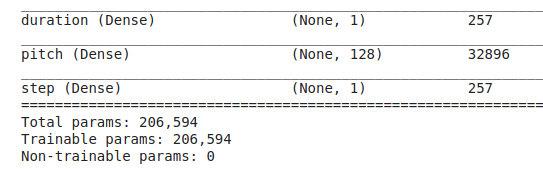

In [40]:
wavenet_losses = wavenet_model.evaluate(train_ds, return_dict=True)
wavenet_losses

274/274 [==============================] - 3s 3ms/step - loss: 5.1375 - duration_loss: 0.2572 - pitch_loss: 4.8550 - step_loss: 0.0252


{'loss': 5.137474060058594,
 'duration_loss': 0.2572444677352905,
 'pitch_loss': 4.855019569396973,
 'step_loss': 0.025208482518792152}

One way balance this is to use the loss_weights argument to compile:

In [41]:
wavenet_model.compile(
    loss=wavenet_loss,
    loss_weights={
        'pitch': 0.02,
        'step': 1.0,
        'duration':0.2,
    },
    optimizer=wavenet_optimizer,
)

The loss then becomes the weighted sum of the individual losses.

In [42]:
wavenet_model.evaluate(train_ds, return_dict=True)

274/274 [==============================] - 1s 3ms/step - loss: 0.1738 - duration_loss: 0.2572 - pitch_loss: 4.8550 - step_loss: 0.0252


{'loss': 0.17375779151916504,
 'duration_loss': 0.2572444677352905,
 'pitch_loss': 4.855019569396973,
 'step_loss': 0.025208482518792152}

In [43]:
wavenet_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/wavenet_ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [44]:
%%time
epochs = 30

history_wavenet = wavenet_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=wavenet_callbacks,
)

Epoch 1/30
274/274 [==============================] - 3s 6ms/step - loss: 0.1427 - duration_loss: 0.1397 - pitch_loss: 4.0944 - step_loss: 0.0329
Epoch 2/30
274/274 [==============================] - 1s 5ms/step - loss: 0.1169 - duration_loss: 0.0815 - pitch_loss: 3.9456 - step_loss: 0.0217
Epoch 3/30
274/274 [==============================] - 1s 5ms/step - loss: 0.1164 - duration_loss: 0.0806 - pitch_loss: 3.9334 - step_loss: 0.0216
Epoch 4/30
274/274 [==============================] - 1s 5ms/step - loss: 0.1153 - duration_loss: 0.0774 - pitch_loss: 3.9238 - step_loss: 0.0213
Epoch 5/30
274/274 [==============================] - 1s 5ms/step - loss: 0.1151 - duration_loss: 0.0768 - pitch_loss: 3.9190 - step_loss: 0.0214
Epoch 6/30
274/274 [==============================] - 1s 5ms/step - loss: 0.1152 - duration_loss: 0.0773 - pitch_loss: 3.9140 - step_loss: 0.0215
Epoch 7/30
274/274 [==============================] - 2s 6ms/step - loss: 0.1147 - duration_loss: 0.0768 - pitch_loss: 3.909

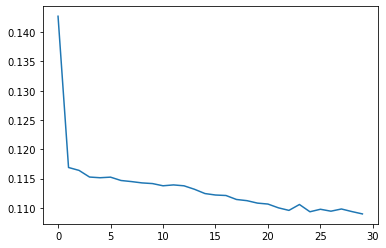

In [45]:
# Plot loss function
plt.plot(history_wavenet.epoch, history_wavenet.history['loss'], label='total loss')
plt.show()

## Generate notes

To use the model to generate notes, you will first need to provide a starting sequence of notes. The function below generates one note from a sequence of notes.

For note pitch, it draws a sample from softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability. Always picking the note with the highest probability would lead to repetitive sequences of notes being generated.

The temperature parameter can be used to control the randomness of notes generated.

In [46]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = keras_model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

Now generate some notes. You can play around with temperature and the starting sequence in `next_notes` and see what happens.

### **LSTM model results**

In [47]:
temperature = 2.0
num_predictions = 100

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes_lstm = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, lstm_model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes_lstm.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes_lstm = pd.DataFrame(
    generated_notes_lstm, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 20ms/step


In [48]:
generated_notes_lstm.head(10)

pitch      step  duration     start       end
0     68  0.148630  0.265280  0.148630  0.413910
1     87  0.119228  0.260347  0.267859  0.528206
2     85  0.132686  0.361798  0.400545  0.762343
3     85  0.144537  0.460871  0.545082  1.005953
4     87  0.147978  0.477858  0.693060  1.170917
5     91  0.144328  0.467302  0.837388  1.304689
6     92  0.142416  0.457013  0.979804  1.436817
7     84  0.143154  0.463329  1.122958  1.586287
8     85  0.144934  0.469432  1.267893  1.737324
9     87  0.145788  0.469593  1.413681  1.883273

In [49]:
out_file_lstm = 'output.mid'
out_pm_lstm = notes_to_midi(
    generated_notes_lstm, out_file=out_file_lstm, instrument_name=instrument_name)
display_audio(out_pm_lstm)

Visualize the generated notes.

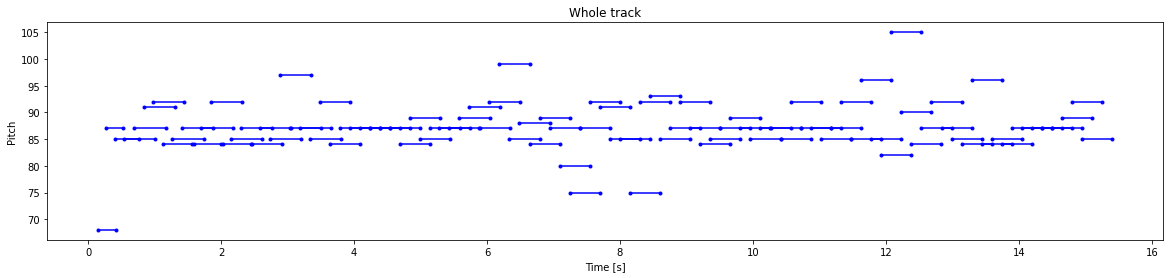

In [50]:
plot_piano_roll(generated_notes_lstm)

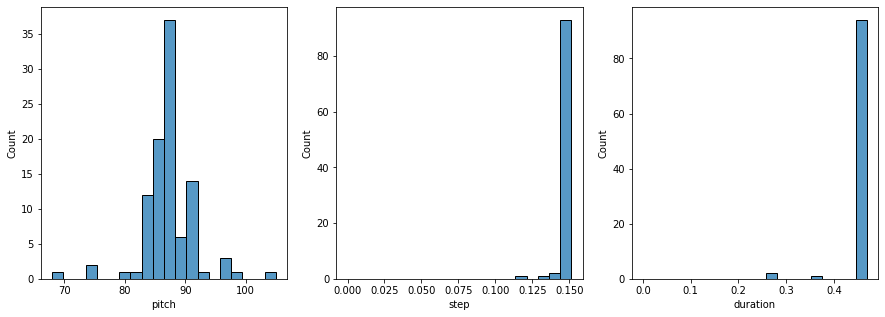

In [51]:
plot_distributions(generated_notes_lstm)

In the above plots, you will notice the change in distribution of the note variables. Since there is a feedback loop between the model's outputs and inputs, the model tends to generate similar sequences of outputs to reduce the loss. This is particularly relevant for step and duration, which has uses MSE loss. For pitch, you can increase the randomness by increasing the temperature in `predict_next_note`.

### **WaveNet model**

In [52]:
temperature = 2.0
num_predictions = 100

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes_wavenet = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, wavenet_model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes_wavenet.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes_wavenet = pd.DataFrame(
    generated_notes_wavenet, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 17ms/step


In [53]:
generated_notes_wavenet.head(10)

pitch      step  duration      start        end
0     29  0.133360  0.301750   0.133360   0.435110
1    105  0.407273  0.000000   0.540633   0.540633
2    105  2.238531  0.000000   2.779165   2.779165
3    105  1.859522  0.000000   4.638686   4.638686
4    105  1.605976  0.000000   6.244662   6.244662
5    105  1.722728  0.000000   7.967390   7.967390
6    105  1.857098  0.000000   9.824488   9.824488
7    105  1.769561  0.000000  11.594049  11.594049
8     99  2.927729  2.690179  14.521778  17.211957
9     99  3.876028  5.035111  18.397807  23.432918

In [54]:
out_file_wavenet = 'output_wavenet.mid'
out_pm_wavenet = notes_to_midi(
    generated_notes_wavenet, out_file=out_file_wavenet, instrument_name=instrument_name)
display_audio(out_pm_wavenet)

Visualize the generated notes.

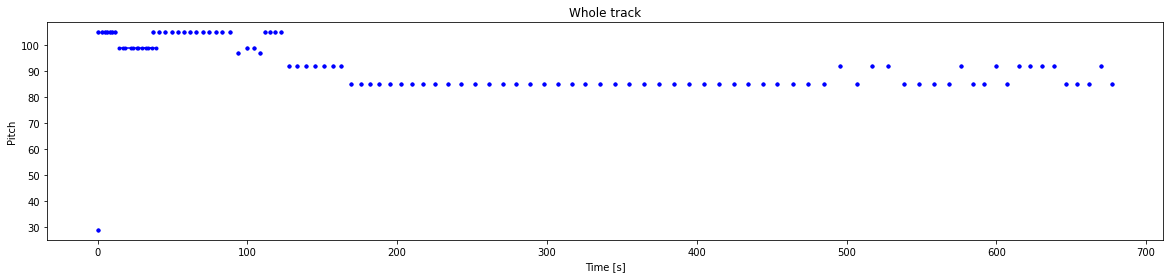

In [55]:
plot_piano_roll(generated_notes_wavenet)

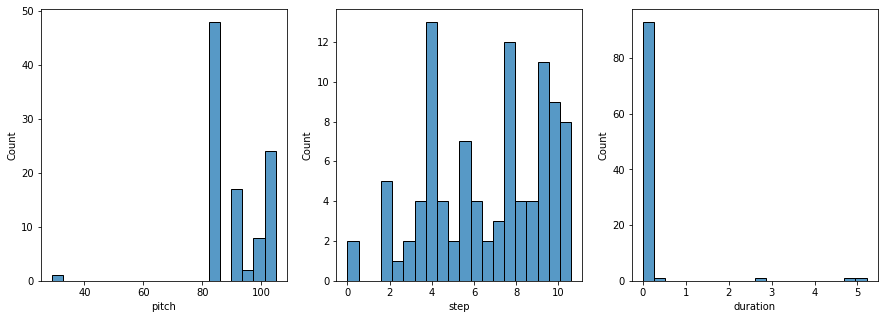

In [56]:
plot_distributions(generated_notes_wavenet)

#Conclusions
###I have tried 100, 150, 300 seq variants, and all of them were not perfect for both models. The current result (using 100 seq len) is decent for LSTM and quite bad for WaveNet. The pitch is too closely-grouped. With seq_len = 300 the WaveNet pitch was above ~90 all the time, so the models are still not perfect and need better tuning.